In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

### Loading dataset

In [2]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "./PreprocessedAll5/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})
print(df_train_kaggle.shape)

(9796, 2)


Text(0, 0.5, 'count')

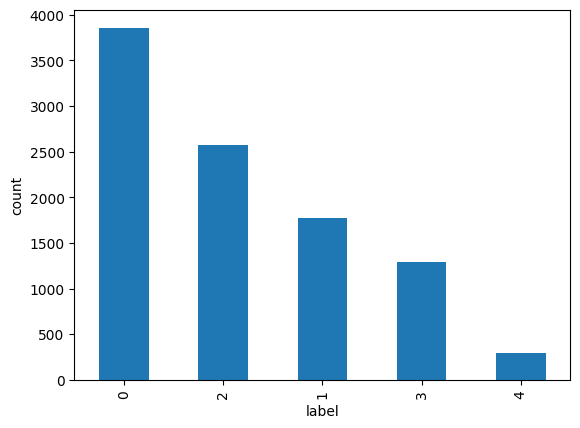

In [3]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

We can see class imbalance here in the data

In [4]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9796 validated image filenames.


### Preparing validation and test data

In [13]:
compi_root_path= "./PreprocessedValidation/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"Val Data/" + x)
df_val_compi.head()

,filename,label
0,./PreprocessedValidation/Val Data/Image_1.jpg,0
1,./PreprocessedValidation/Val Data/Image_2.jpg,1
2,./PreprocessedValidation/Val Data/Image_3.jpg,0
3,./PreprocessedValidation/Val Data/Image_4.jpg,1
4,./PreprocessedValidation/Val Data/Image_5.jpg,2


Text(0, 0.5, 'count')

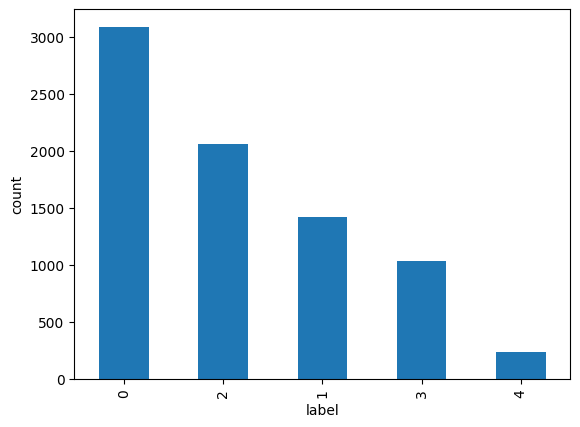

In [14]:
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [16]:
# Step 1: Split validation data into x_val and x_test
x_val, x_test = train_test_split(df_val_compi, test_size=0.35, random_state=42)

# Create separate generators for x_val and x_test
val_generator = valid_aug.flow_from_dataframe(
    dataframe=x_val,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)

test_generator = valid_aug.flow_from_dataframe(
    dataframe=x_test,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)

Found 5088 validated image filenames.
Found 2740 validated image filenames.


### Baseline Model - VGG19 with basic transfer learning

In [17]:
# checking if CUDA is working fine

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU acceleration enabled!")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

✅ GPU acceleration enabled!


In [18]:
# ✅ Enable GPU memory growth for TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU acceleration enabled!")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")
    
# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Combine the base model with custom classification head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

✅ GPU acceleration enabled!
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (N

In [19]:
# training the model

hist=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
307/307 [==============================] - 70s 227ms/step - loss: 1.3993 - accuracy: 0.3935 - val_loss: 1.3758 - val_accuracy: 0.4051
Epoch 2/10
307/307 [==============================] - 46s 151ms/step - loss: 1.3441 - accuracy: 0.4328 - val_loss: 1.3083 - val_accuracy: 0.4202
Epoch 3/10
307/307 [==============================] - 50s 163ms/step - loss: 1.2964 - accuracy: 0.4486 - val_loss: 1.2701 - val_accuracy: 0.4536
Epoch 4/10
307/307 [==============================] - 48s 157ms/step - loss: 1.2619 - accuracy: 0.4562 - val_loss: 1.2325 - val_accuracy: 0.4768
Epoch 5/10
307/307 [==============================] - 47s 155ms/step - loss: 1.2378 - accuracy: 0.4661 - val_loss: 1.2401 - val_accuracy: 0.4733
Epoch 6/10
307/307 [==============================] - 50s 162ms/step - loss: 1.2241 - accuracy: 0.4723 - val_loss: 1.2039 - val_accuracy: 0.4778
Epoch 7/10
307/307 [==============================] - 49s 159ms/step - loss: 1.2094 - accuracy: 0.4817 - val_loss: 1.2153 - val_ac

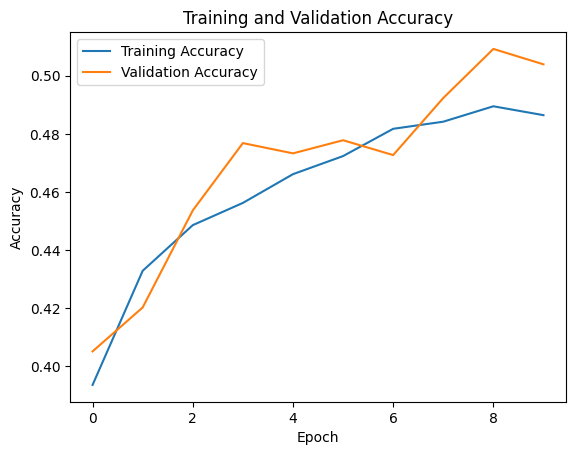

In [20]:
# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

86/86 [==============================] - 19s 220ms/step
Confusion Matrix:
[[982   1 102   9   3]
 [403   1  79   7   2]
 [423   2 232  71   5]
 [127   0  91  91  27]
 [ 10   0  12  18  42]]


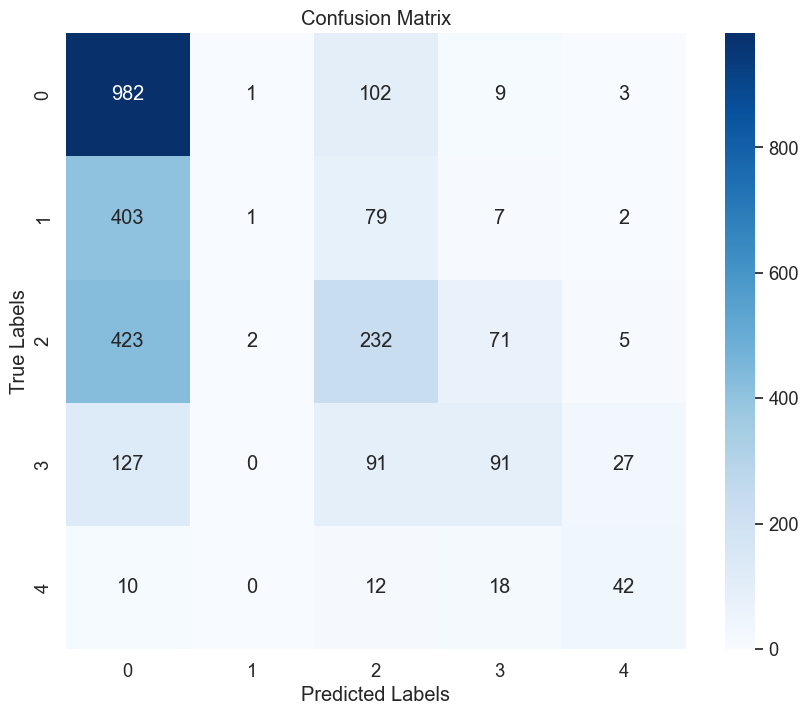

In [21]:
# Step 2: Use your model to predict labels for x_test
predictions = model.predict(test_generator)

# Step 3: Evaluate the predictions using a confusion matrix
true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.90      0.65      1097
           1       0.25      0.00      0.00       492
           2       0.45      0.32      0.37       733
           3       0.46      0.27      0.34       336
           4       0.53      0.51      0.52        82

    accuracy                           0.49      2740
   macro avg       0.44      0.40      0.38      2740
weighted avg       0.44      0.49      0.42      2740



This classification report reveals performance difficulties in classifying classes 1,2 and 3. The significant class imbalance underscores the 
importance of the F1-score, which offers a more robust evaluation metric than accuracy 
alone. Epoch 8 likely represents the optimal training point; further iterations could 
lead to overfitting and reduced generalization performance. This pattern is reinforced by the 
confusion matrix, which emphasizes misclassifications within classes 1, 2, and 3. 
To enhance results, we'll be exploring alternative feature engineering techniques, model 
architectures, or hyperparameter optimization.

In [26]:
# Saving the vgg19 model with the best checkpoint

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# Corrected checkpoint path
checkpoint_path = "vgg19_best.weights.h5"  # Ensure it ends with `.weights.h5`
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define callbacks
my_callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_acc',  # Ensure 'val_acc' exists in model metrics
                    verbose=1,
                    save_weights_only=True,
                    save_best_only=True,
                    mode="max"),
    EarlyStopping(monitor='val_loss',
                  patience=5,
                  verbose=1),
    ReduceLROnPlateau(monitor='val_loss',
                      patience=5,
                      verbose=1)
]

### VGG19 with Imagenet weights and Convolution Layers

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

# Global pooling layer
GAP = GlobalAveragePooling2D()(x)

# Output layer
n_classes = 5  # Number of classes in your output
pred = Dense(n_classes, activation='softmax')(GAP)

# Define the model
vgg19_model = Model(inputs=base_model.input, outputs=pred)

# Compile the model
vgg19_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

vgg19_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [28]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

# Train the model

history = vgg19_model.fit(
    train_generator,
    epochs=22,
    validation_data=val_generator,
    callbacks=[my_callbacks],
    class_weight=class_weights
)

Epoch 1/22
307/307 [==============================] - ETA: 0s - loss: 1.3550 - acc: 0.3096
Epoch 1: val_acc improved from -inf to 0.46266, saving model to vgg19_best.weights.h5
307/307 [==============================] - 54s 170ms/step - loss: 1.3550 - acc: 0.3096 - val_loss: 1.3859 - val_acc: 0.4627 - lr: 1.0000e-05
Epoch 2/22
307/307 [==============================] - ETA: 0s - loss: 1.1603 - acc: 0.4449
Epoch 2: val_acc did not improve from 0.46266
307/307 [==============================] - 51s 165ms/step - loss: 1.1603 - acc: 0.4449 - val_loss: 1.3299 - val_acc: 0.4450 - lr: 1.0000e-05
Epoch 3/22
307/307 [==============================] - ETA: 0s - loss: 1.0699 - acc: 0.4972
Epoch 3: val_acc improved from 0.46266 to 0.49862, saving model to vgg19_best.weights.h5
307/307 [==============================] - 51s 165ms/step - loss: 1.0699 - acc: 0.4972 - val_loss: 1.2210 - val_acc: 0.4986 - lr: 1.0000e-05
Epoch 4/22
307/307 [==============================] - ETA: 0s - loss: 0.9896 - acc:

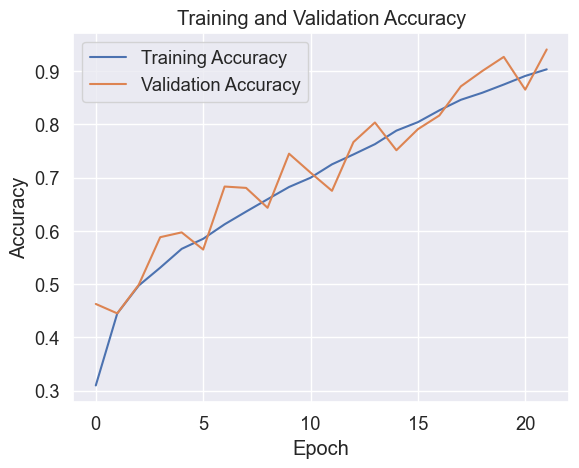

In [29]:
# Plot training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

86/86 [==============================] - 10s 114ms/step
Confusion Matrix:


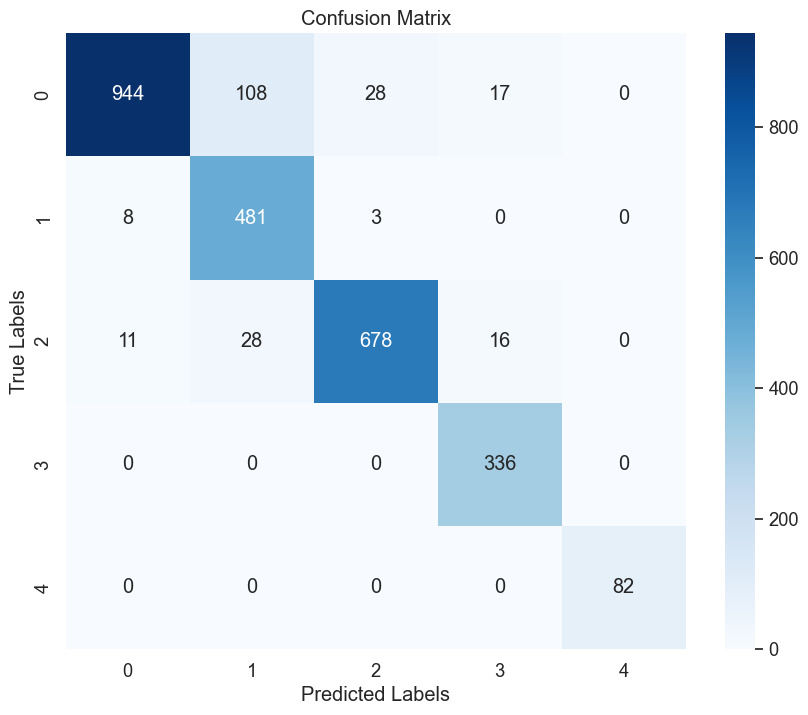

In [30]:
vgg19_model.load_weights(checkpoint_path)

# Step 2: Use your model to predict labels for x_test
predictions = vgg19_model.predict(test_generator)

# Step 3: Evaluate the predictions using a confusion matrix
true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1097
           1       0.78      0.98      0.87       492
           2       0.96      0.92      0.94       733
           3       0.91      1.00      0.95       336
           4       1.00      1.00      1.00        82

    accuracy                           0.92      2740
   macro avg       0.93      0.95      0.94      2740
weighted avg       0.93      0.92      0.92      2740



In [32]:
vgg19_model.save('vgg19_model.h5')